# 1. Setting up Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import torch
import torch.nn
import matplotlib.pyplot as plt
from meld.recon import UnrolledNetwork
from meld.util import getAbs, getPhase
from meld.model import pytorch_proximal
from torch.utils.data import Dataset
import h5py
# local
import mri
# import hqs
import model
import dataloader
import lib_complex as cp

In [2]:
test_layer = pytorch_proximal.ResNet4(num_filters=64,num_layers=5)

In [3]:
test_layer

ResNet4(
  (model): Sequential(
    (conv1): Conv2dSame(
      (net): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (relu1): ReLU()
    (conv2): Conv2dSame(
      (net): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (relu2): ReLU()
    (conv3): Conv2dSame(
      (net): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (relu3): ReLU()
    (conv4): Conv2dSame(
      (net): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (relu4): ReLU()
    (conv5): Conv2dSame(
      (net): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1))
      )
    )
  )
)

In [4]:
# Setup device
device_no = 1
torch.cuda.set_device(device_no)
device = torch.device("cuda:"+str(device_no) if torch.cuda.is_available() else "cpu")

np_dtype = np.float32
device

device(type='cuda', index=1)

In [6]:
datapath = '/home/kellman/Workspace/DATA/dataset_train_full.h5'
dataset = dataloader.dataloader(datapath, 
                                noise_std = 1e-5)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
imgs, maps, meas, mask = dataset[150]

imgs_test = imgs.unsqueeze(0).to(device)
maps_test = maps.unsqueeze(0).to(device)
meas_test = meas.unsqueeze(0).to(device)
mask_test = mask.unsqueeze(0).to(device)

print(imgs_test.shape, maps_test.shape, meas_test.shape, mask_test.shape)

torch.Size([1, 256, 232, 2]) torch.Size([1, 12, 256, 232, 2]) torch.Size([1, 12, 256, 232, 2]) torch.Size([1, 256, 232])


In [7]:
out = mri.maps_forw(imgs_test, maps_test)
print(out.shape)

# check gradient with backprop

torch.Size([1, 12, 256, 232, 2])


## Setup Model

In [8]:
mri_model = mri.MultiChannelMRI(device = device)
adjoint = mri_model.batch(imgs_test, maps_test, meas_test, mask_test, device)
zeros_test = torch.zeros_like(adjoint).to(device)
with torch.no_grad():
    recon = mri_model(zeros_test, device = device, max_iter=100)

## Forward Reverse test
prints the normalized rmse between input and reverse for different number of unrolled conjugate gradient iterations

In [9]:
with torch.no_grad():
    reverse = mri_model.reverse(recon, device = device)

<IPython.core.display.Javascript object>


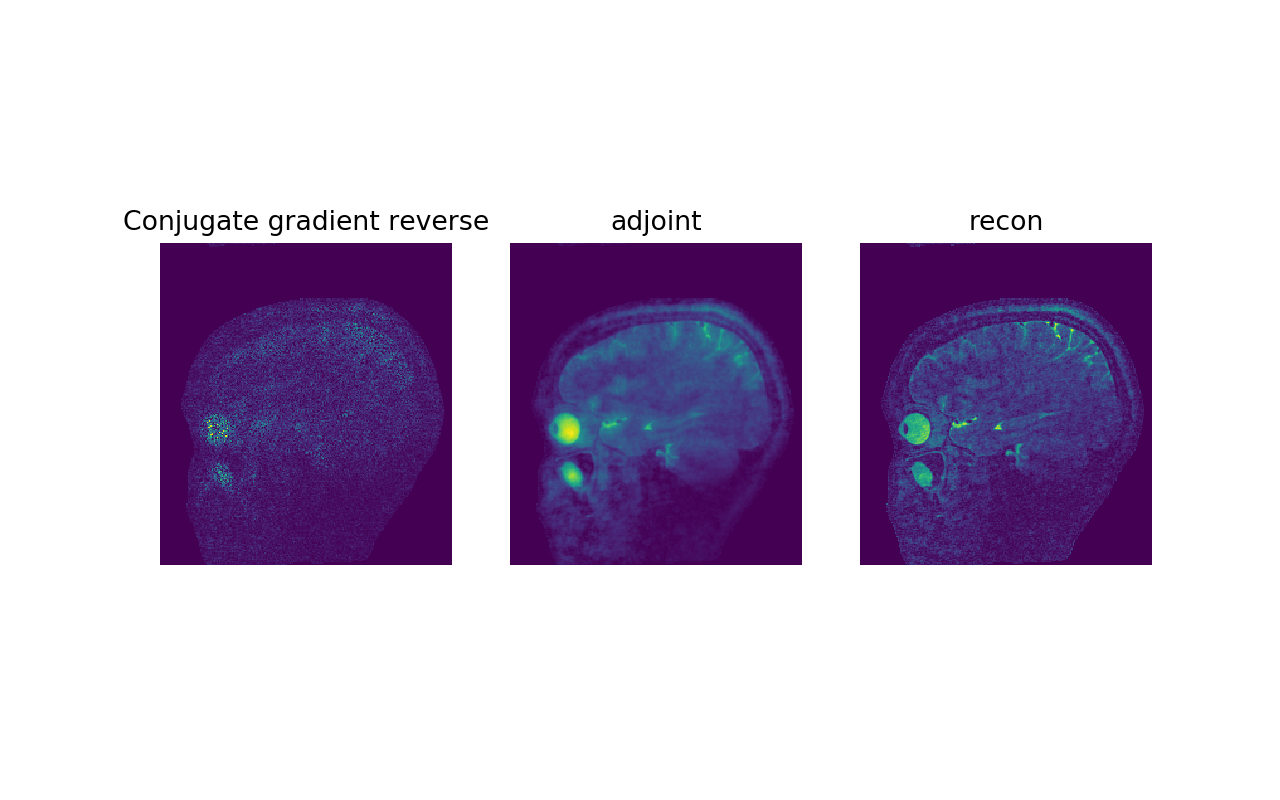

Text(0.5, 1.0, 'recon')

In [10]:
plt.figure(figsize=(8,5))
plt.subplot(131)
plt.imshow(getAbs(reverse[0,...]).cpu().numpy())
plt.axis('off')
plt.title('Conjugate gradient reverse')
plt.subplot(132)
plt.imshow(getAbs(adjoint[0,...]).cpu().numpy())
plt.axis('off')
plt.title('adjoint')
plt.subplot(133)
plt.imshow(getAbs(recon[0,...]).cpu().numpy())
plt.axis('off')
plt.title('recon')


In [10]:
print(torch.sum((getAbs(reverse[0,...]) - getAbs(zeros_test[0,...]))**2) / (256 * 232))

tensor(7.7510e-13, device='cuda:1')


In [19]:
metadata = {'num_unrolls': 10, 'lamb': 1.0, 'alpha': 1e-2}

In [20]:
mri_network_manager = model.model(metadata, device=device, debug=False, shrinkage_params=(1, 1), num_layers=5, num_filters=64)

In [46]:
gradient_check_manager = model.model(metadata, device=device, debug=False, shrinkage_params=(1, 1), num_layers=5, num_filters=64)
optimizer_check = torch.optim.Adam(gradient_check_manager.network.parameters(), lr=1e-5)
gradient_check_unroller = UnrolledNetwork(gradient_check_manager.network, None, 11000, loss_func, device=device, setupFlag=False)

In [21]:
optimizer = torch.optim.Adam(mri_network_manager.network.parameters(), lr=1e-5)

In [22]:
loss_func = lambda x1, x2: torch.mean((x1-x2)**2)

In [23]:
mri_network_unroller = UnrolledNetwork(mri_network_manager.network, None, 11000, loss_func, device=device, setupFlag=False)
mri_network_unroller.meldFlag = True
mri_network_unroller.cpList = [-1]

In [24]:
stats = []

In [54]:
mri_network_manager.network

ModuleList(
  (0): ModuleList(
    (0): MultiChannelMRI()
    (1): ResNet4(
      (model): Sequential(
        (conv1): Conv2dSame(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (relu1): ReLU()
        (conv2): Conv2dSame(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (relu2): ReLU()
        (conv3): Conv2dSame(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (relu3): ReLU()
        (conv4): Conv2dSame(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (relu4): ReLU()
        (conv5): Conv2dSam

In [ ]:
%%notify
#30
# learning rate, batchnorm?
# add command to run until specified time, not iteration?
for i in range(70):
    print(f'iteration {i}')
    for i_batch, sample_batched in enumerate(data_loader):
        imgs_0, maps_0, meas_0, mask_0 = sample_batched
    #     print(imgs_0.size(), maps_0.size(), meas_0.size(), mask_0.size())
        adj_0 = gradient_check_manager.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    #     print(adj_0.size())
    #     print(mri_network_manager.prox(adj_0).size())
    #     print(input_data.size())
        gradient_check_unroller.network.zero_grad()
        xN, loss_temp, _, _ = gradient_check_unroller.forward(torch.zeros_like(adj_0), imgs_0.to(device))
        print(f'batch {i_batch} of 90, loss: {loss_temp.item()}')
        optimizer_check.step()

iteration 0
batch 0 of 90, loss: 0.03851335495710373
batch 1 of 90, loss: 0.038393784314394
batch 2 of 90, loss: 0.03942808136343956
batch 3 of 90, loss: 0.048725761473178864
batch 4 of 90, loss: 0.03461707755923271
batch 5 of 90, loss: 0.04193270951509476
batch 6 of 90, loss: 0.044363316148519516
batch 7 of 90, loss: 0.05072535574436188
batch 8 of 90, loss: 0.03414066880941391
batch 9 of 90, loss: 0.03509075194597244
batch 10 of 90, loss: 0.030094671994447708
batch 11 of 90, loss: 0.026128357276320457
batch 12 of 90, loss: 0.033491894602775574
batch 13 of 90, loss: 0.024733634665608406
batch 14 of 90, loss: 0.02865109220147133
batch 15 of 90, loss: 0.0463203489780426
batch 16 of 90, loss: 0.0350165031850338
batch 17 of 90, loss: 0.03243863582611084
batch 18 of 90, loss: 0.028973743319511414
batch 19 of 90, loss: 0.030903365463018417
batch 20 of 90, loss: 0.025769034400582314
batch 21 of 90, loss: 0.0362553708255291
batch 22 of 90, loss: 0.03379109874367714
batch 23 of 90, loss: 0.0280

batch 13 of 90, loss: 0.022741295397281647
batch 14 of 90, loss: 0.024590322747826576
batch 15 of 90, loss: 0.029642868787050247
batch 16 of 90, loss: 0.025690095499157906
batch 17 of 90, loss: 0.023027995601296425
batch 18 of 90, loss: 0.02896198444068432
batch 19 of 90, loss: 0.023007214069366455
batch 20 of 90, loss: 0.02583819255232811
batch 21 of 90, loss: 0.029519714415073395
batch 22 of 90, loss: 0.023430144414305687
batch 23 of 90, loss: 0.0208115354180336
batch 24 of 90, loss: 0.026012051850557327
batch 25 of 90, loss: 0.020394887775182724
batch 26 of 90, loss: 0.021930275484919548
batch 27 of 90, loss: 0.025125090032815933
batch 28 of 90, loss: 0.03194453939795494
batch 29 of 90, loss: 0.027487676590681076
batch 30 of 90, loss: 0.022719856351614
batch 31 of 90, loss: 0.02448955550789833
batch 32 of 90, loss: 0.0270244050770998
batch 33 of 90, loss: 0.026415135711431503
batch 34 of 90, loss: 0.037608031183481216
batch 35 of 90, loss: 0.03030356578528881
batch 36 of 90, loss: 0

batch 26 of 90, loss: 0.023445554077625275
batch 27 of 90, loss: 0.020981457084417343
batch 28 of 90, loss: 0.02879934385418892
batch 29 of 90, loss: 0.027332786470651627
batch 30 of 90, loss: 0.025237543508410454
batch 31 of 90, loss: 0.03089144267141819
batch 32 of 90, loss: 0.03092430904507637
batch 33 of 90, loss: 0.023854263126850128
batch 34 of 90, loss: 0.028939025476574898
batch 35 of 90, loss: 0.024224115535616875
batch 36 of 90, loss: 0.019993672147393227
batch 37 of 90, loss: 0.0246520284563303
batch 38 of 90, loss: 0.0190688818693161
batch 39 of 90, loss: 0.02297605760395527
batch 40 of 90, loss: 0.024371320381760597
batch 41 of 90, loss: 0.02279863879084587
batch 42 of 90, loss: 0.02786732278764248
batch 43 of 90, loss: 0.02400565892457962
batch 44 of 90, loss: 0.02403086982667446
batch 45 of 90, loss: 0.028378929942846298
batch 46 of 90, loss: 0.025579044595360756
batch 47 of 90, loss: 0.029694195836782455
batch 48 of 90, loss: 0.02348491922020912
batch 49 of 90, loss: 0.

batch 39 of 90, loss: 0.020813841372728348
batch 40 of 90, loss: 0.018313387408852577
batch 41 of 90, loss: 0.02239951677620411
batch 42 of 90, loss: 0.03987137973308563
batch 43 of 90, loss: 0.0316995233297348
batch 44 of 90, loss: 0.018972808495163918
batch 45 of 90, loss: 0.02268240600824356
batch 46 of 90, loss: 0.025729171931743622
batch 47 of 90, loss: 0.028776884078979492
batch 48 of 90, loss: 0.016738001257181168
batch 49 of 90, loss: 0.017434366047382355
batch 50 of 90, loss: 0.025027383118867874
batch 51 of 90, loss: 0.019991574808955193
batch 52 of 90, loss: 0.020505433902144432
batch 53 of 90, loss: 0.023842284455895424
batch 54 of 90, loss: 0.020511802285909653
batch 55 of 90, loss: 0.01800367794930935
batch 56 of 90, loss: 0.022456269711256027
batch 57 of 90, loss: 0.02514638938009739
batch 58 of 90, loss: 0.026952208951115608
batch 59 of 90, loss: 0.02439386211335659
batch 60 of 90, loss: 0.027053318917751312
batch 61 of 90, loss: 0.028602642938494682
batch 62 of 90, los

batch 52 of 90, loss: 0.028700940310955048
batch 53 of 90, loss: 0.035256244242191315
batch 54 of 90, loss: 0.022194579243659973
batch 55 of 90, loss: 0.023946397006511688
batch 56 of 90, loss: 0.02178993634879589
batch 57 of 90, loss: 0.0187210850417614
batch 58 of 90, loss: 0.021780693903565407
batch 59 of 90, loss: 0.028502918779850006
batch 60 of 90, loss: 0.021308820694684982
batch 61 of 90, loss: 0.0231331754475832
batch 62 of 90, loss: 0.03268370032310486
batch 63 of 90, loss: 0.03226393833756447
batch 64 of 90, loss: 0.01941904053092003
batch 65 of 90, loss: 0.02393116056919098
batch 66 of 90, loss: 0.024969903752207756
batch 67 of 90, loss: 0.028080109506845474
batch 68 of 90, loss: 0.029660044237971306
batch 69 of 90, loss: 0.02652900665998459
batch 70 of 90, loss: 0.022677132859826088
batch 71 of 90, loss: 0.023990200832486153
batch 72 of 90, loss: 0.022150496020913124
batch 73 of 90, loss: 0.02162475325167179
batch 74 of 90, loss: 0.02058354578912258
batch 75 of 90, loss: 0

In [ ]:
%%notify
# 100
# add command to run until specified time, not iteration?
for i in range(10):
    print(f'iteration {i}')
    for i_batch, sample_batched in enumerate(data_loader):
        imgs_0, maps_0, meas_0, mask_0 = sample_batched
    #     print(imgs_0.size(), maps_0.size(), meas_0.size(), mask_0.size())
        adj_0 = mri_network_manager.initialize(imgs_0.to(device), maps_0.to(device), meas_0.to(device), mask_0.to(device), device)
    #     print(adj_0.size())
    #     print(mri_network_manager.prox(adj_0).size())
    #     print(input_data.size())
        mri_network_unroller.network.zero_grad()
        xN, loss_temp, _, _ = mri_network_unroller.forward(torch.zeros_like(adj_0), imgs_0.to(device))
        print(f'batch {i_batch} of 90, loss: {loss_temp.item()}')
        optimizer.step()

iteration 0
batch 0 of 90, loss: 0.01996014267206192
batch 1 of 90, loss: 0.03059307113289833
batch 2 of 90, loss: 0.025524957105517387
batch 3 of 90, loss: 0.018706006929278374
batch 4 of 90, loss: 0.018393445760011673
batch 5 of 90, loss: 0.02512611821293831
batch 6 of 90, loss: 0.023412561044096947
batch 7 of 90, loss: 0.025685550644993782
batch 8 of 90, loss: 0.02518412098288536
batch 9 of 90, loss: 0.023285211995244026
batch 10 of 90, loss: 0.020970724523067474
batch 11 of 90, loss: 0.02289040945470333
batch 12 of 90, loss: 0.019771503284573555
batch 13 of 90, loss: 0.023229118436574936
batch 14 of 90, loss: 0.029061058536171913
batch 15 of 90, loss: 0.02566949650645256
batch 16 of 90, loss: 0.021275516599416733
batch 17 of 90, loss: 0.027559703215956688
batch 18 of 90, loss: 0.02385515533387661
batch 19 of 90, loss: 0.022207634523510933
batch 20 of 90, loss: 0.02805459313094616
batch 21 of 90, loss: 0.016237016767263412
batch 22 of 90, loss: 0.0204989705234766
batch 23 of 90, los

batch 13 of 90, loss: 0.023492617532610893
batch 14 of 90, loss: 0.02248835749924183
batch 15 of 90, loss: 0.023875229060649872
batch 16 of 90, loss: 0.017074231058359146
batch 17 of 90, loss: 0.02954765409231186
batch 18 of 90, loss: 0.022006159648299217
batch 19 of 90, loss: 0.028174029663205147
batch 20 of 90, loss: 0.020497946068644524
batch 21 of 90, loss: 0.024054376408457756
batch 22 of 90, loss: 0.022553440183401108
batch 23 of 90, loss: 0.02270318754017353
batch 24 of 90, loss: 0.029539773240685463
batch 25 of 90, loss: 0.019928455352783203
batch 26 of 90, loss: 0.023370208218693733
batch 27 of 90, loss: 0.025996195152401924
batch 28 of 90, loss: 0.02301054634153843
batch 29 of 90, loss: 0.027415022253990173
batch 30 of 90, loss: 0.02995295263826847
batch 31 of 90, loss: 0.017926553264260292
batch 32 of 90, loss: 0.021630266681313515
batch 33 of 90, loss: 0.02020411565899849
batch 34 of 90, loss: 0.024640703573822975
batch 35 of 90, loss: 0.02120368555188179
batch 36 of 90, lo

batch 25 of 90, loss: 0.02431396208703518
batch 26 of 90, loss: 0.019060248509049416
batch 27 of 90, loss: 0.016726521775126457
batch 28 of 90, loss: 0.024087006226181984
batch 29 of 90, loss: 0.0222917553037405
batch 30 of 90, loss: 0.02685011364519596
batch 31 of 90, loss: 0.02529013156890869
batch 32 of 90, loss: 0.02211209014058113
batch 33 of 90, loss: 0.027066882699728012
batch 34 of 90, loss: 0.026373188942670822
batch 35 of 90, loss: 0.02602143958210945
batch 36 of 90, loss: 0.02489016391336918
batch 37 of 90, loss: 0.02220808155834675
batch 38 of 90, loss: 0.023745523765683174
batch 39 of 90, loss: 0.016656728461384773
batch 40 of 90, loss: 0.01853163354098797
batch 41 of 90, loss: 0.02011939324438572
batch 42 of 90, loss: 0.029346700757741928
batch 43 of 90, loss: 0.019846726208925247
batch 44 of 90, loss: 0.028376862406730652
batch 45 of 90, loss: 0.022986195981502533
batch 46 of 90, loss: 0.0193904060870409
batch 47 of 90, loss: 0.02326868288218975
batch 48 of 90, loss: 0.0

batch 38 of 90, loss: 0.02228873409330845
batch 39 of 90, loss: 0.021887442097067833
batch 40 of 90, loss: 0.026603754609823227
batch 41 of 90, loss: 0.026379363611340523
batch 42 of 90, loss: 0.024442043155431747
batch 43 of 90, loss: 0.022248223423957825
batch 44 of 90, loss: 0.019835807383060455
batch 45 of 90, loss: 0.022035570815205574
batch 46 of 90, loss: 0.022479398176074028
batch 47 of 90, loss: 0.02075219340622425
batch 48 of 90, loss: 0.027119306847453117
batch 49 of 90, loss: 0.030128955841064453
batch 50 of 90, loss: 0.023202545940876007
batch 51 of 90, loss: 0.02465536817908287
batch 52 of 90, loss: 0.02618907205760479


In [33]:
print(mri_network_manager.network)

ModuleList(
  (0): ModuleList(
    (0): MultiChannelMRI()
    (1): ResNet4(
      (model): Sequential(
        (conv1): Conv2dSame(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (relu1): ReLU()
        (conv2): Conv2dSame(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (relu2): ReLU()
        (conv3): Conv2dSame(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (relu3): ReLU()
        (conv4): Conv2dSame(
          (net): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
          )
        )
        (relu4): ReLU()
        (conv5): Conv2dSam

In [25]:
print(len([p for p in mri_network_manager.network[0][1].parameters()]))

1


In [19]:
%%notify
for i in range(100):
    x0 = adjoint
    mri_network_unroller.network.zero_grad()
    _, loss_temp, _, _ = mri_network_unroller.forward(x0, imgs_0)
    print(loss_temp.item())
    stats.append(loss_temp)
    optimizer.step()

RuntimeError: expected device cuda:1 and dtype Float but got device cpu and dtype Float

<IPython.core.display.Javascript object>

In [55]:
adj_test = mri_network_manager.initialize(imgs.unsqueeze(0).to(device), maps.unsqueeze(0).to(device), meas.unsqueeze(0).to(device), mask.unsqueeze(0).to(device), device)
x, loss_temp = mri_network_unroller.loss_eval(adj_test.to(device), imgs.to(device))
print(adj_test.shape)
print(x.shape)

torch.Size([1, 256, 232, 2])
torch.Size([1, 256, 232, 2])


In [56]:
print(torch.sum((getAbs(adj_test[0,...]) - getAbs(x[0,...]))**2) / (256 * 232))

tensor(0.0025, device='cuda:1')


<IPython.core.display.Javascript object>


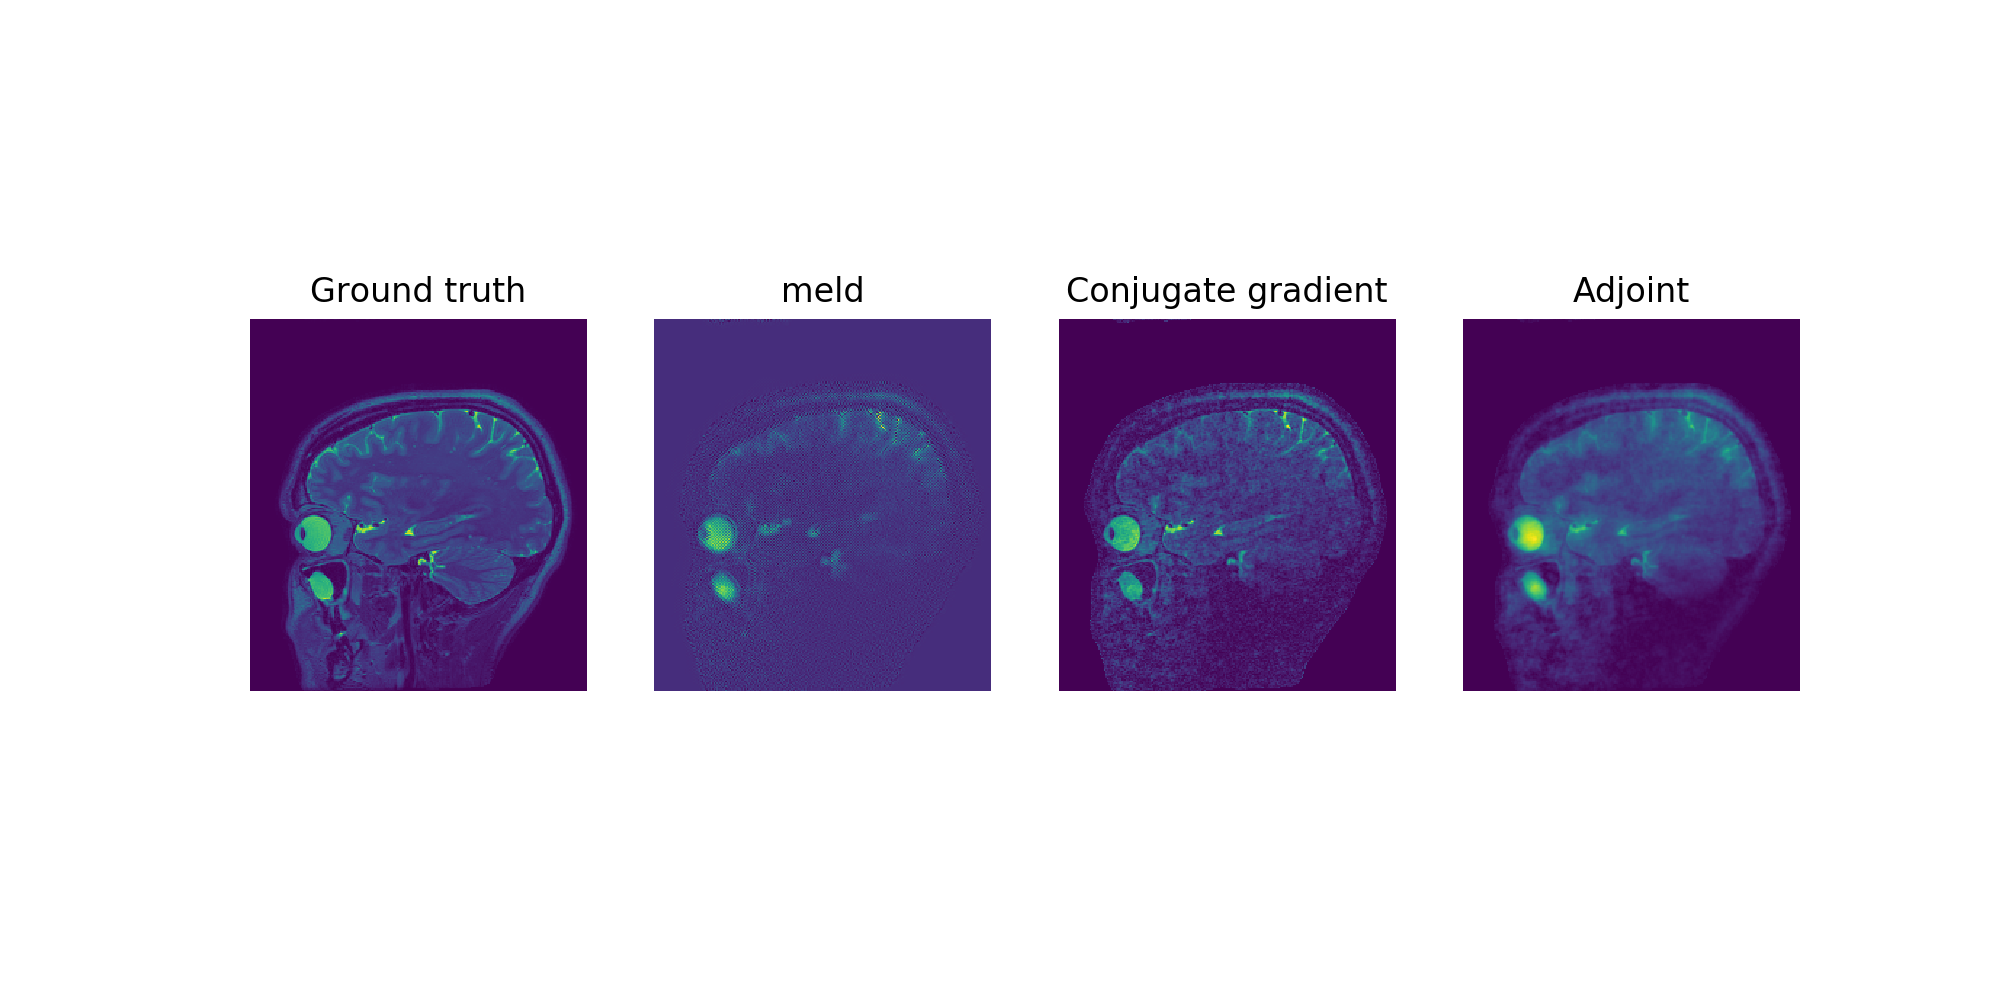

Text(0.5, 1.0, 'Adjoint')

In [57]:
plt.figure(figsize=(10,5))
plt.subplot(141)
plt.imshow(getAbs(imgs).cpu().numpy())
plt.axis('off')
plt.title('Ground truth')
plt.subplot(142)
plt.imshow(getAbs(x[0,...]).cpu().numpy())
plt.axis('off')
plt.title('meld')
plt.subplot(143)
plt.imshow(getAbs(recon[0,...]).cpu().numpy())
plt.axis('off')
plt.title('Conjugate gradient')
plt.subplot(144)
plt.imshow(getAbs(adjoint[0,...]).cpu().numpy())
plt.axis('off')
plt.title('Adjoint')

In [ ]:
test_3 = pytorch_proximal.ResNet3().to(device)
test_4 = pytorch_proximal.ResNet4().to(device)

In [ ]:
test_4(recon).size()

In [ ]:
loss_func(recon, imgs_0)

In [ ]:
plt.figure()
plt.plot(list(range(len(stats))), stats)
plt.xscale('log')
plt.yscale('log')
plt.show()